In [5]:
import os
import pandas as pd
root_dir = 'C:\Vinh\Python\Machine Learning\Skin condition detection\Kaggle\IMG_CLASSES'

image_paths = []
labels = []

labels_dict = {
    "1. Eczema 1677": "Eczema",
    "2. Melanoma 15.75k": "Melanoma",
    "3. Atopic Dermatitis - 1.25k": "Atopic Dermatitis",
    "4. Basal Cell Carcinoma (BCC) 3323": "Basal Cell Carcinoma",
    "5. Melanocytic Nevi (NV) - 7970": "Melanocytic Nevi",
    "6. Benign Keratosis-like Lesions (BKL) 2624": "Benign Keratosis-like Lesions",
    "7. Psoriasis pictures Lichen Planus and related diseases - 2k": "Psoriasis pictures Lichen Planus and related diseases",
    "8. Seborrheic Keratoses and other Benign Tumors - 1.8k": "Seborrheic Keratoses and other Benign Tumors",
    "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k": "Tinea Ringworm Candidiasis and other Fungal Infections",
    "10. Warts Molluscum and other Viral Infections - 2103": "Warts Molluscum and other Viral Infections"
}

for label in os.listdir(root_dir):
    label_dir = os.path.join(root_dir, label)
    if os.path.isdir(label_dir):
        for filename in os.listdir(label_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')): 
                image_paths.append(os.path.join(label_dir, filename))
                labels.append(labels_dict[label])

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

df = df.sample(frac=1).reset_index(drop=True)

print(df.head())

                                          image_path  \
0  C:\Vinh\Python\Machine Learning\Skin condition...   
1  C:\Vinh\Python\Machine Learning\Skin condition...   
2  C:\Vinh\Python\Machine Learning\Skin condition...   
3  C:\Vinh\Python\Machine Learning\Skin condition...   
4  C:\Vinh\Python\Machine Learning\Skin condition...   

                                               label  
0                                   Melanocytic Nevi  
1         Warts Molluscum and other Viral Infections  
2                                   Melanocytic Nevi  
3  Tinea Ringworm Candidiasis and other Fungal In...  
4       Seborrheic Keratoses and other Benign Tumors  


C:\Users\Vinh\AppData\Local\Temp\ipykernel_29044\2210118981.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


<Axes: xlabel='label'>

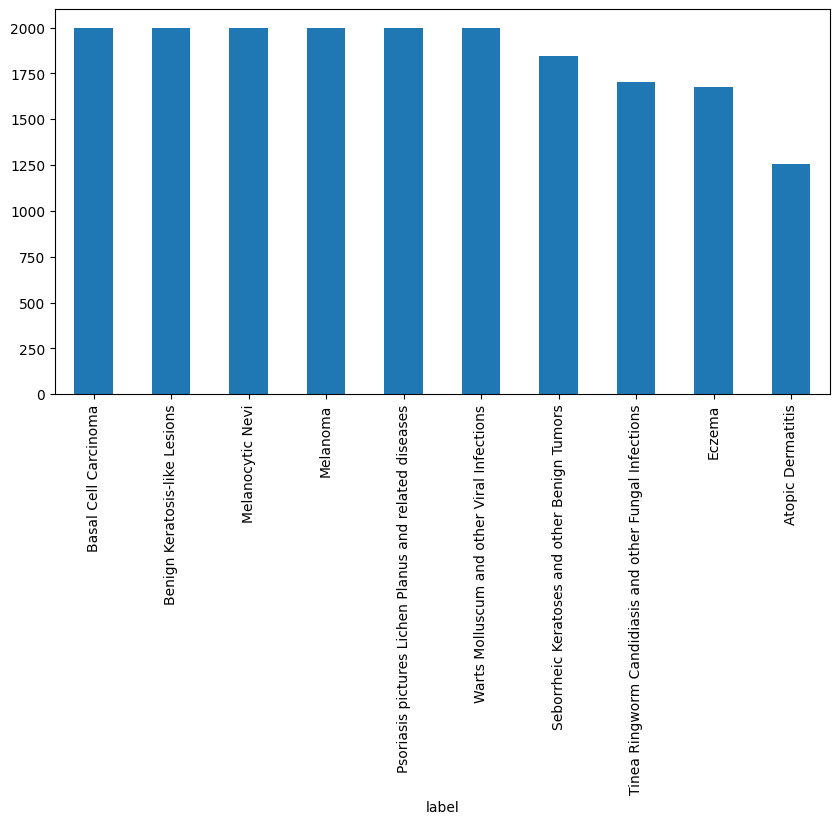

In [6]:
max_images_per_class = 2000

df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['label'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
pip install torchinfo

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time

from typing import List, Text

from PIL import Image

import numpy as np
import pandas as pd
import tabulate


import tensorflow as tf

import matplotlib.pyplot as plt

In [7]:
condition_to_index = {condition: idx for idx, condition in enumerate(labels_dict.values())}
def conditions_to_binary_matrix(condition, condition_to_index):
    binary_matrix = np.zeros(len(condition_to_index))
    if condition in condition_to_index:
        binary_matrix[condition_to_index[condition]] = 1
    return binary_matrix
binary_labels = np.array([conditions_to_binary_matrix(cond, condition_to_index)
                          for cond in df["label"]])

print(len(binary_labels))
print(binary_labels)
print(binary_labels[5])

18483
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Image shape: (100, 75, 3)
Image min value: 0.0117647061124444
Image max value: 0.8117647171020508


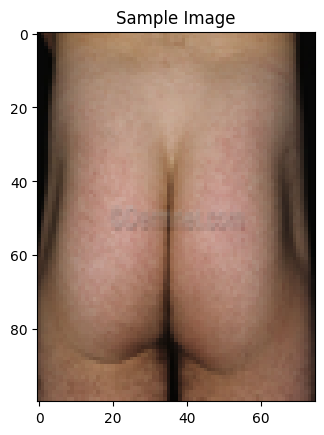

In [8]:
def load_and_preprocess_image(image_path, target_size=(75, 100)):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(target_size)
        image = np.array(image, dtype=np.float32) / 255.0
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros(target_size + (3,), dtype=np.float32)
image_path = df["image_path"][0]
image = load_and_preprocess_image(image_path)
print(f"Image shape: {image.shape}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")

plt.imshow(image)
plt.title("Sample Image")
plt.show()

In [9]:
from torchvision import transforms
from PIL import Image
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_and_preprocess_image(path, target_size):
    img = Image.open(path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    return img


def process_images(df, batch_size=100, target_size=(75, 100), max_workers=8):
    all_images = []
    
    def load_image(path):
        return load_and_preprocess_image(path, target_size)
    
    num_images = len(df)
    
    for start in range(0, num_images, batch_size):
        batch_paths = df['image_path'].iloc[start:start + batch_size]
        batch_images = []
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(load_image, path) for path in batch_paths]
            for future in as_completed(futures):
                img = future.result()
                if img.max() == 0:
                    print(f"Warning: Image in batch is all zeros.")
                batch_images.append(img)

        all_images.append(np.array(batch_images, dtype=np.float32))
    
    return np.concatenate(all_images, axis=0)

batch_size = 100  
images = process_images(df, batch_size=batch_size)

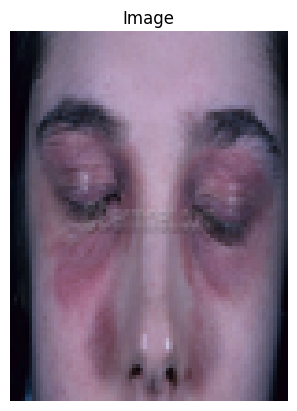

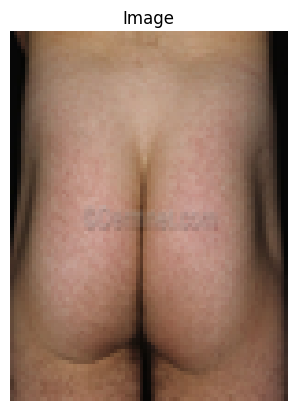

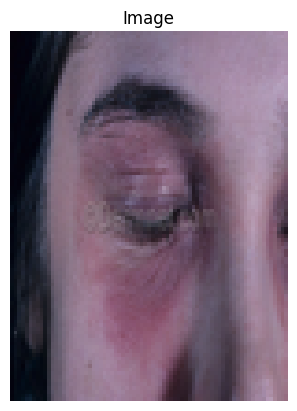

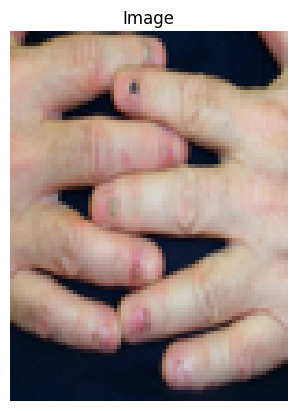

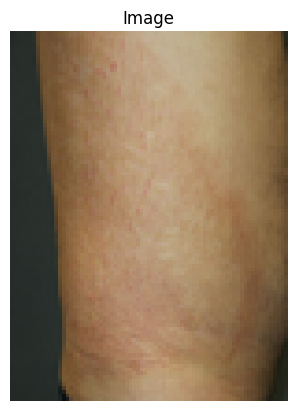

In [10]:
import matplotlib.pyplot as plt

def show_image(image, title="Image"):
    if image.ndim == 3 and image.shape[2] == 3:  
        plt.imshow(image)
    else:
        plt.imshow(image, cmap='gray') 
    plt.title(title)
    plt.axis('off')
    plt.show()
for i in range(5):
    show_image(images[i])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, binary_labels, test_size=0.2, random_state=1234)

In [12]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

print("Number of samples in X_train:", X_train.shape[0])
print("Number of samples in X_val:", X_val.shape[0])
print("Number of samples in y_train:", y_train.shape[0])
print("Number of samples in y_val:", y_val.shape[0])

X_train shape: (14786, 100, 75, 3)
X_val shape: (3697, 100, 75, 3)
y_train shape: (14786, 10)
y_val shape: (3697, 10)
Number of samples in X_train: 14786
Number of samples in X_val: 3697
Number of samples in y_train: 14786
Number of samples in y_val: 3697


In [14]:
from PIL import Image
import torch

def preprocess_image(image):
    if image.ndim == 2:  # Grayscale image
        return (image * 255).astype(np.uint8)
    elif image.ndim == 3 and image.shape[0] == 1:  # Single channel grayscale
        return (image.squeeze(0) * 255).astype(np.uint8)
    elif image.ndim == 3 and image.shape[0] == 3:  # RGB image
        return (np.transpose(image, (1, 2, 0)) * 255).astype(np.uint8)
    else:
        raise ValueError("Unexpected image format: shape {}".format(image.shape))

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Preprocess the image based on its type
        image = preprocess_image(image)

        # Convert to PIL image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [34]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(75, 100), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])
train_dataset = AugmentedDataset(images=X_train, labels=y_train, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

val_transforms = transforms.Compose([
    transforms.Resize((75, 100)),
    transforms.ToTensor()
])
val_dataset = AugmentedDataset(images=X_val, labels=y_val, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

Images batch shape: torch.Size([32, 3, 75, 100])
Labels batch shape: torch.Size([32, 10])


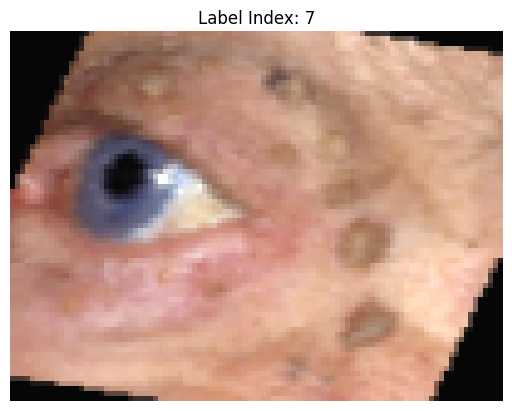

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def preprocess_image(image):
    if len(image.shape) == 3:  
        return (image * 255).astype(np.uint8)  
    elif len(image.shape) == 4:
        return (image[0] * 255).astype(np.uint8)
    else:
        raise ValueError("Unexpected image format.")

def visualize_batch(train_loader):
    for images, labels in train_loader:
        print(f"Images batch shape: {images.shape}")
        print(f"Labels batch shape: {labels.shape}")
        
        image = images[0].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        
        if image.shape[2] == 1:  # Grayscale image
            image = image[:, :, 0]
        elif image.shape[2] == 3:  # RGB image
            pass
        else:
            raise ValueError("Unexpected image format for visualization.")
        
        plt.imshow(image)
        plt.axis('off')
        
        label = labels[0].numpy()
        label_index = np.argmax(label) 
        plt.title(f"Label Index: {label_index}")
        
        plt.show()
        break  

visualize_batch(train_loader)




In [36]:
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary

class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomDenseNet121, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        self.base_model.classifier = nn.Identity()  

        self.fc1 = nn.Linear(1024, 512) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomDenseNet121(num_classes=10).to(device)

dummy_input = torch.randn(1, 3, 75, 100).to(device)

model(dummy_input)

summary(model, input_size=(1, 3, 75, 100))




Layer (type:depth-idx)                        Output Shape              Param #
CustomDenseNet121                             [1, 10]                   --
├─DenseNet: 1-1                               [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 1024, 2, 3]           --
│    │    └─Conv2d: 3-1                       [1, 64, 38, 50]           9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 38, 50]           128
│    │    └─ReLU: 3-3                         [1, 64, 38, 50]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 19, 25]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 19, 25]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 9, 12]           33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 9, 12]           919,680
│    │    └─_Transition: 3-8                  [1, 256, 4, 6]            132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 4, 6]           

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-5
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def one_hot_to_class_indices(one_hot_labels):
    return one_hot_labels.argmax(dim=1)

def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        class_indices = one_hot_to_class_indices(labels)
        loss = criterion(outputs, class_indices)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == class_indices).sum().item()
        total += labels.size(0)
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

def evaluate_model(model, val_loader, criterion, scheduler, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, one_hot_to_class_indices(labels))  
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += one_hot_to_class_indices(labels).size(0) 
            correct += (predicted == one_hot_to_class_indices(labels)).sum().item() 

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    scheduler.step(accuracy)
    return avg_loss


In [38]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5)
num_epochs = 20

for epoch in range(num_epochs):
    print(device)
    train_model(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss = evaluate_model(model, val_loader, criterion, scheduler, device)
    
    early_stopping(val_loss)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:46<00:00,  4.35batch/s]


Training Loss: 2.2670, Accuracy: 21.95%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 14.67batch/s]


Validation Loss: 2.1781, Accuracy: 31.21%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:36<00:00,  4.80batch/s]


Training Loss: 2.1099, Accuracy: 36.24%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.03batch/s]


Validation Loss: 2.0489, Accuracy: 42.17%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:36<00:00,  4.81batch/s]


Training Loss: 2.0365, Accuracy: 43.30%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 15.65batch/s]


Validation Loss: 1.9884, Accuracy: 47.96%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:35<00:00,  4.86batch/s]


Training Loss: 1.9700, Accuracy: 50.36%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 16.48batch/s]


Validation Loss: 1.9297, Accuracy: 53.96%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:34<00:00,  4.89batch/s]


Training Loss: 1.9302, Accuracy: 53.44%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 16.42batch/s]


Validation Loss: 1.9063, Accuracy: 55.99%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:35<00:00,  4.85batch/s]


Training Loss: 1.9077, Accuracy: 55.96%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.94batch/s]


Validation Loss: 1.8981, Accuracy: 56.56%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:36<00:00,  4.82batch/s]


Training Loss: 1.8854, Accuracy: 58.11%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.98batch/s]


Validation Loss: 1.8704, Accuracy: 59.86%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:39<00:00,  4.65batch/s]


Training Loss: 1.8688, Accuracy: 60.06%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 16.50batch/s]


Validation Loss: 1.8446, Accuracy: 62.35%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:33<00:00,  4.95batch/s]


Training Loss: 1.8477, Accuracy: 62.13%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.83batch/s]


Validation Loss: 1.8512, Accuracy: 61.16%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:33<00:00,  4.94batch/s]


Training Loss: 1.8289, Accuracy: 63.95%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.23batch/s]


Validation Loss: 1.8521, Accuracy: 60.59%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:33<00:00,  4.94batch/s]


Training Loss: 1.8267, Accuracy: 63.83%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.61batch/s]


Validation Loss: 1.8200, Accuracy: 64.24%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:33<00:00,  4.96batch/s]


Training Loss: 1.8137, Accuracy: 65.17%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 17.29batch/s]


Validation Loss: 1.8265, Accuracy: 63.40%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:29<00:00,  5.16batch/s]


Training Loss: 1.8082, Accuracy: 65.65%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.94batch/s]


Validation Loss: 1.8101, Accuracy: 64.86%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:34<00:00,  4.90batch/s]


Training Loss: 1.8002, Accuracy: 66.43%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.74batch/s]


Validation Loss: 1.8061, Accuracy: 65.54%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:33<00:00,  4.94batch/s]


Training Loss: 1.7911, Accuracy: 67.19%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.91batch/s]


Validation Loss: 1.8031, Accuracy: 65.86%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:33<00:00,  4.95batch/s]


Training Loss: 1.7865, Accuracy: 67.88%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.81batch/s]


Validation Loss: 1.8161, Accuracy: 64.30%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:34<00:00,  4.92batch/s]


Training Loss: 1.7813, Accuracy: 68.29%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:06<00:00, 16.92batch/s]


Validation Loss: 1.7893, Accuracy: 67.32%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:46<00:00,  4.35batch/s]


Training Loss: 1.7734, Accuracy: 68.99%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:08<00:00, 13.71batch/s]


Validation Loss: 1.8052, Accuracy: 65.86%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:50<00:00,  4.18batch/s]


Training Loss: 1.7682, Accuracy: 69.78%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:07<00:00, 14.62batch/s]


Validation Loss: 1.7891, Accuracy: 66.97%
cuda


Training: 100%|███████████████████████████████████████████████████████████████████| 463/463 [01:50<00:00,  4.20batch/s]


Training Loss: 1.7631, Accuracy: 70.26%


Validation: 100%|█████████████████████████████████████████████████████████████████| 116/116 [00:08<00:00, 13.06batch/s]

Validation Loss: 1.7968, Accuracy: 66.22%


Predicted class index: 7
tensor([[0.0854, 0.0853, 0.0853, 0.0853, 0.0854, 0.0853, 0.0854, 0.2318, 0.0854,
         0.0854]], device='cuda:0')


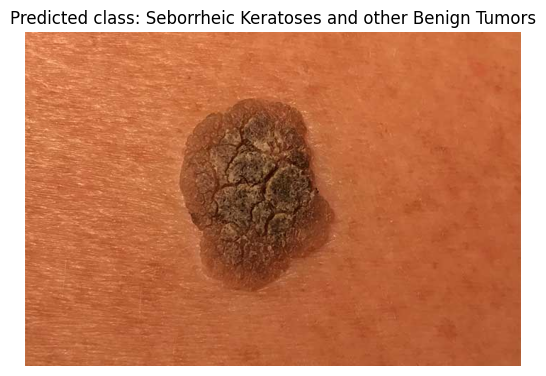

In [40]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import urllib.request
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((75, 100)),
    transforms.ToTensor(),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

image_url = "https://contourderm.com/wp-content/uploads/2014/07/20190227-Seborrheic-Keratosis-web.jpg"
try:
    with urllib.request.urlopen(image_url) as response:
        img = Image.open(response).convert('RGB')  # Ensure the image is in RGB format

    image = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        print(f"Predicted class index: {predicted.item()}")
        probabilities = F.softmax(outputs, dim=1)
        print(probabilities)

    labels_arr = list(labels_dict.values())
    plt.imshow(img)
    plt.title(f'Predicted class: {labels_arr[predicted.item()]}')
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


In [41]:
torch.save(model, 'model.pth')